In [1]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) # Limiting floating points to 3

In [71]:
train = pd.read_excel(r'Cf_Re1.xls',sheetname='InputData')
test = pd.read_excel(r'Cf_Re1.xls',sheetname='Prediction')
train = train[train['value']<0.6]
test = test[test['value']<0.6]

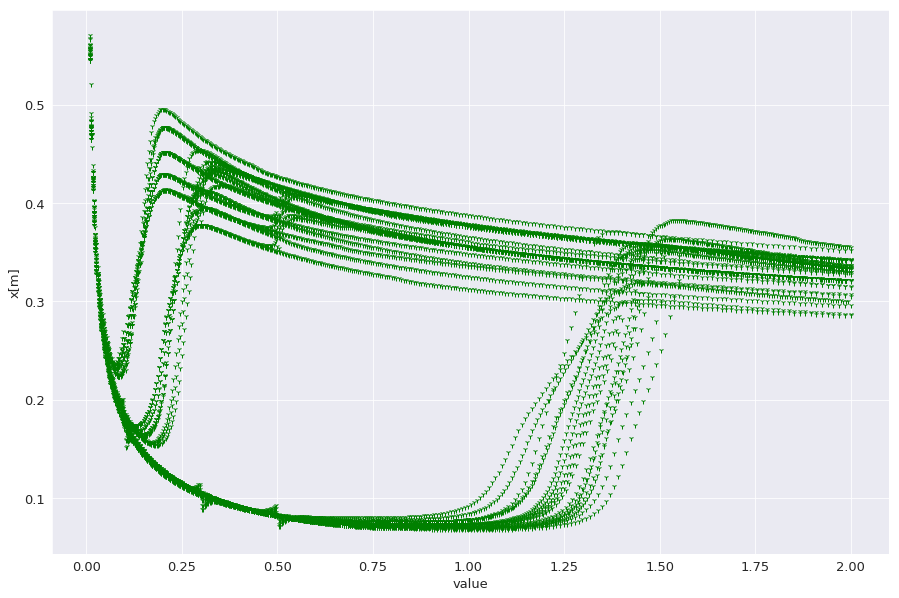

In [72]:
## Plotting traning data
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(train['x [m]'],train['value'],'g1')
plt.ylabel('x[m]', fontsize=13)
plt.xlabel('value', fontsize=13)
plt.show()


 mu = 0.27 and sigma = 0.13



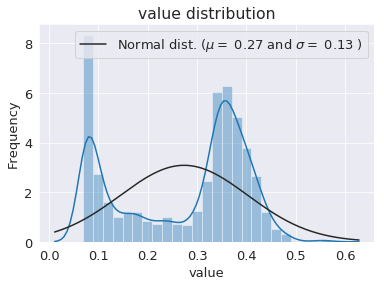

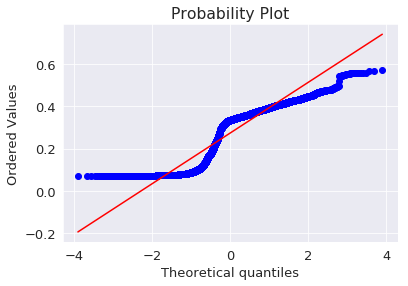

In [73]:
sns.distplot(train['value'] , fit=norm)
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['value'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('value distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['value'], plot=plt)
plt.show()

In [74]:
## concatenate the traning and testing dataframes
ntrain = train.shape[0]
ntest = test.shape[0]
x_train = train.drop('value',axis=1)
y_train = train['value'].values
y_test = test['value'].values
x_test = test.drop('value',axis=1)
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['value'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))
x_train

all_data size is : (14746, 4)


,x [m],Tu,ζ [m],ΔT [K]
2,0.015,1,0.100,-50
3,0.020,1,0.100,-50
4,0.025,1,0.100,-50
5,0.030,1,0.100,-50
6,0.035,1,0.100,-50
7,0.040,1,0.100,-50
8,0.045,1,0.100,-50
9,0.050,1,0.100,-50
10,0.055,1,0.100,-50
11,0.060,1,0.100,-50


In [75]:
## find NaN values
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio


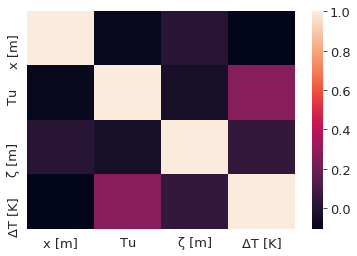

In [76]:
# correlations between variables
corr_matrix = x_train.corr()
heatmap = sns.heatmap(corr_matrix)

In [77]:
## MODELING
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import cross_val_score,cross_val_predict,KFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [104]:
#Validation function
n_folds = 5

def rmsle_cv(model,type=None):
    
    rmse= np.sqrt(-cross_val_score(model, x_train.values, y_train, scoring="neg_mean_squared_error", cv = n_folds))
    return(rmse)

In [79]:
"""
# hyper parameter testing for lasso and elasticNet since they have
# similar effects on alpha value
alphas = np.sort(np.array([0.00005,0.0005,0.005,0.003,0.01,0.009,0.05,0.5]))
LassoScores = []
eNetScores = []
for alpha in alphas:
    # Lasso
    lasso = make_pipeline(RobustScaler(), Lasso(alpha =alpha, random_state=1))
    score = rmsle_cv(lasso)
    LassoScores.append(score.mean())
    # ElasticNet
    ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=alpha, l1_ratio=.9, random_state=3))
    score = rmsle_cv(ENet)
    eNetScores.append(score.mean())
        
print('the lowest score found on Lasso was = %.7f with the alpha value of %.5f' % (np.amin(LassoScores),alphas[np.argmin(LassoScores)]))
print('the lowest score found on Elastic Net was = %.7f with the alpha value of %.5f' % (np.amin(eNetScores),alphas[np.argmin(eNetScores)]))
"""

"\n# hyper parameter testing for lasso and elasticNet since they have\n# similar effects on alpha value\nalphas = np.sort(np.array([0.00005,0.0005,0.005,0.003,0.01,0.009,0.05,0.5]))\nLassoScores = []\neNetScores = []\nfor alpha in alphas:\n    # Lasso\n    lasso = make_pipeline(RobustScaler(), Lasso(alpha =alpha, random_state=1))\n    score = rmsle_cv(lasso)\n    LassoScores.append(score.mean())\n    # ElasticNet\n    ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=alpha, l1_ratio=.9, random_state=3))\n    score = rmsle_cv(ENet)\n    eNetScores.append(score.mean())\n        \nprint('the lowest score found on Lasso was = %.7f with the alpha value of %.5f' % (np.amin(LassoScores),alphas[np.argmin(LassoScores)]))\nprint('the lowest score found on Elastic Net was = %.7f with the alpha value of %.5f' % (np.amin(eNetScores),alphas[np.argmin(eNetScores)]))\n"

In [80]:
"""
# Plot score-alpha graphs
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(alphas,LassoScores,color='green')
ax[1].plot(alphas,eNetScores,color='red')
plt.xlabel('alpha')
plt.ylabel('scores')
plt.show()
"""

"\n# Plot score-alpha graphs\nfig,ax = plt.subplots(1,2,figsize=(10,5))\nax[0].plot(alphas,LassoScores,color='green')\nax[1].plot(alphas,eNetScores,color='red')\nplt.xlabel('alpha')\nplt.ylabel('scores')\nplt.show()\n"

In [81]:
# Lasso is very sensitive with outliers so we need a robust scaler.
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.005, random_state=1))

In [82]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.009, l1_ratio=.9, random_state=3))

In [83]:
KRR = KernelRidge(alpha=1, kernel='polynomial', degree=2, coef0=2.5)

In [84]:
# hyper parameter testing for Kernel Ridge Regression
"""
alphas = np.array([0.001,0.01,0.1,1])
coefs = [0.25,2.5,10,25]
fig,ax = plt.subplots(1,4,figsize=(10,5))
plt.xlabel('alphas')
plt.ylabel('scores')
scores = []
for i,coef in enumerate(coefs):
    ax[i].set_title('coef0: '+str(coef))
    for alpha in alphas:
        krr = KernelRidge(alpha=alpha,kernel='polynomial',degree=2,coef0=coef)
        score = rmsle_cv(krr)
        scores.append(score.mean())
    ax[i].plot(alphas,scores[4*i:4*i+4])
plt.show()
min_alpha_index = ((np.argmin(scores)+1)//4+(np.argmin(scores)+1)%4)-1
min_coef_index = (np.argmin(scores)+1)/4-1
print('the lowest score found on Kernel Ridge Regression was = %.7f with the alpha value of %.5f and coef0 value of %.2f' % (np.amin(scores),alphas[min_alpha_index],coefs[min_coef_index]))
"""

"\nalphas = np.array([0.001,0.01,0.1,1])\ncoefs = [0.25,2.5,10,25]\nfig,ax = plt.subplots(1,4,figsize=(10,5))\nplt.xlabel('alphas')\nplt.ylabel('scores')\nscores = []\nfor i,coef in enumerate(coefs):\n    ax[i].set_title('coef0: '+str(coef))\n    for alpha in alphas:\n        krr = KernelRidge(alpha=alpha,kernel='polynomial',degree=2,coef0=coef)\n        score = rmsle_cv(krr)\n        scores.append(score.mean())\n    ax[i].plot(alphas,scores[4*i:4*i+4])\nplt.show()\nmin_alpha_index = ((np.argmin(scores)+1)//4+(np.argmin(scores)+1)%4)-1\nmin_coef_index = (np.argmin(scores)+1)/4-1\nprint('the lowest score found on Kernel Ridge Regression was = %.7f with the alpha value of %.5f and coef0 value of %.2f' % (np.amin(scores),alphas[min_alpha_index],coefs[min_coef_index]))\n"

In [85]:
# huber loose makes it robust to outliers
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [86]:
#model_xgb = xgb.XGBRegressor()

In [87]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [88]:
# pack up models in a list for easy use
models = [GBoost,model_lgb,ENet,lasso,KRR]

In [89]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

In [90]:
def build_model():
    model = Sequential()
    
    ## Input Layer
    model.add(Dense(32, kernel_initializer='normal',input_dim = x_train.shape[1], activation='relu'))
    
    ## Hidden Layers
    for r in range(3):
        model.add(Dense(32*2, kernel_initializer='normal',activation='relu'))
    
    model.add(Dense(1, kernel_initializer='normal',activation='linear'))
    
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    
    return model

In [91]:
# Checkpoint to keep track of best weight matrices
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [92]:
# finding the best model architecture
# first, keep hidden layers as twice the size of hidden for all
"""
inputs = [16,32,64]
repeats = [2,3,4]
fig,ax = plt.subplots(3,3,figsize=(12,12))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
for x,i in enumerate(inputs):
    for y,r in enumerate(repeats):
        NN_model = build_model(i,r)
        history = NN_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)
        ax[x,y].plot(history.history['loss'])
        ax[x,y].plot(history.history['val_loss'])
        ax[x,y].set_title('Hidden = %d, Repeats = %d' % (i*2,r))
plt.show()
"""

"\ninputs = [16,32,64]\nrepeats = [2,3,4]\nfig,ax = plt.subplots(3,3,figsize=(12,12))\nplt.ylabel('loss')\nplt.xlabel('epoch')\nplt.title('model loss')\nplt.legend(['train', 'test'], loc='upper left')\nfor x,i in enumerate(inputs):\n    for y,r in enumerate(repeats):\n        NN_model = build_model(i,r)\n        history = NN_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)\n        ax[x,y].plot(history.history['loss'])\n        ax[x,y].plot(history.history['val_loss'])\n        ax[x,y].set_title('Hidden = %d, Repeats = %d' % (i*2,r))\nplt.show()\n"

In [93]:
# Creating a KerasRegressor to use ANN with scikit-learn later
ANNRegressor = KerasRegressor(build_fn=build_model,epochs=100,batch_size=64,validation_split = 0.2)
ANNRegressor.fit(x_train,y_train)
pred = ANNRegressor.predict(x_test)

Train on 11534 samples, validate on 2884 samples
Epoch 1/100
11534/11534 [==============================] - 1s 50us/step - loss: 0.1047 - mean_absolute_error: 0.1047 - val_loss: 0.0534 - val_mean_absolute_error: 0.0534
Epoch 2/100
11534/11534 [==============================] - 0s 24us/step - loss: 0.0765 - mean_absolute_error: 0.0765 - val_loss: 0.1073 - val_mean_absolute_error: 0.1073
Epoch 3/100
11534/11534 [==============================] - 0s 25us/step - loss: 0.0597 - mean_absolute_error: 0.0597 - val_loss: 0.0743 - val_mean_absolute_error: 0.0743
Epoch 4/100
11534/11534 [==============================] - 0s 27us/step - loss: 0.0493 - mean_absolute_error: 0.0493 - val_loss: 0.0444 - val_mean_absolute_error: 0.0444
Epoch 5/100
11534/11534 [==============================] - 0s 23us/step - loss: 0.0408 - mean_absolute_error: 0.0408 - val_loss: 0.0911 - val_mean_absolute_error: 0.0911
Epoch 6/100
11534/11534 [==============================] - 0s 28us/step - loss: 0.0357 - mean_absolut

Epoch 49/100
11534/11534 [==============================] - 0s 26us/step - loss: 0.0092 - mean_absolute_error: 0.0092 - val_loss: 0.0336 - val_mean_absolute_error: 0.0336
Epoch 50/100
11534/11534 [==============================] - 0s 22us/step - loss: 0.0088 - mean_absolute_error: 0.0088 - val_loss: 0.0255 - val_mean_absolute_error: 0.0255
Epoch 51/100
11534/11534 [==============================] - 0s 24us/step - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.0203 - val_mean_absolute_error: 0.0203
Epoch 52/100
11534/11534 [==============================] - 0s 24us/step - loss: 0.0090 - mean_absolute_error: 0.0090 - val_loss: 0.0256 - val_mean_absolute_error: 0.0256
Epoch 53/100
11534/11534 [==============================] - 0s 25us/step - loss: 0.0092 - mean_absolute_error: 0.0092 - val_loss: 0.0237 - val_mean_absolute_error: 0.0237
Epoch 54/100
11534/11534 [==============================] - 0s 24us/step - loss: 0.0081 - mean_absolute_error: 0.0081 - val_loss: 0.0229 - val_me

Epoch 97/100
11534/11534 [==============================] - 0s 23us/step - loss: 0.0054 - mean_absolute_error: 0.0054 - val_loss: 0.0205 - val_mean_absolute_error: 0.0205
Epoch 98/100
11534/11534 [==============================] - 0s 23us/step - loss: 0.0059 - mean_absolute_error: 0.0059 - val_loss: 0.0219 - val_mean_absolute_error: 0.0219
Epoch 99/100
11534/11534 [==============================] - 0s 21us/step - loss: 0.0065 - mean_absolute_error: 0.0065 - val_loss: 0.0125 - val_mean_absolute_error: 0.0125
Epoch 100/100
11534/11534 [==============================] - 0s 24us/step - loss: 0.0053 - mean_absolute_error: 0.0053 - val_loss: 0.0153 - val_mean_absolute_error: 0.0153


In [94]:
# best architecture was hidden = [64,64,64]

In [95]:
# hyperparameter tuning for best_arch
"""
bs = [32,64,128,256]
fig,ax = plt.subplots(1,4,figsize=(12,12))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('model loss')
for i,bs in enumerate(bs):
    history = best_arch.fit(x_train,y_train,epochs=200,batch_size=bs,validation_split=0.2,callbacks=callbacks_list)
    ax[i].plot(history.history['loss'])
    ax[i].plot(history.history['val_loss'])
    ax[i].set_title('Batch_size = %d' % (bs))
plt.show()
"""

"\nbs = [32,64,128,256]\nfig,ax = plt.subplots(1,4,figsize=(12,12))\nplt.ylabel('loss')\nplt.xlabel('epoch')\nplt.title('model loss')\nfor i,bs in enumerate(bs):\n    history = best_arch.fit(x_train,y_train,epochs=200,batch_size=bs,validation_split=0.2,callbacks=callbacks_list)\n    ax[i].plot(history.history['loss'])\n    ax[i].plot(history.history['val_loss'])\n    ax[i].set_title('Batch_size = %d' % (bs))\nplt.show()\n"

In [96]:
# load the best model 
weights_file = 'Weights-081--0.01038.hdf5' # choose the best checkpoint
ANNRegressor.model.load_weights(weights_file) # load it
ANNRegressor.model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [97]:
# make the prediction
prediction = ANNRegressor.predict(x_test,batch_size=64)

In [98]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [99]:
# evaluate the score of ANN
score = rmsle(y_test,prediction)
print("\nANN score: {:.4f}\n".format(score))


ANN score: 0.0083



In [100]:
# squeezing prediction array so we can plot it
prediction = np.squeeze(prediction)

In [101]:
def prediction_graph(prediction,title,figsize):
    # percent error
    percent_error = np.multiply(np.abs(np.divide(np.subtract(y_test,prediction),y_test)),100)
    score = rmsle(y_test,prediction)
    # plot to show percent error and predicted values
    fig,(ax1,ax3) = plt.subplots(2,1,figsize=figsize)
    plt.title(title)
    color = 'tab:red'
    ax1.set_xlabel('x [m]')
    ax1.set_ylabel('values', color=color)
    ln1 = ax1.plot(x_test['x [m]'],prediction,'r--',label='prediction')
    ln2 = ax1.plot(x_test['x [m]'],y_test,'g1',label='test')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('percent error', color=color)  # we already handled the x-label with ax1
    ln3 = ax2.plot(x_test['x [m]'], percent_error, color=color,label='error(in percentage)')
    ax2.tick_params(axis='y', labelcolor=color)
    lns = ln1+ln2+ln3
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=0)
    ax1.grid()
    font = {'family' : 'normal',
        'size'   : 13}

    plt.rc('font', **font)
    ax3.set_xlabel('true values')
    ax3.set_ylabel('predicted values', color=color)
    ax3.plot(y_test,prediction,'g1')
    xx = np.linspace(*ax3.get_xlim())
    ax3.plot(xx, xx,color='red')
    plt.grid(True)
    plt.show()
    return score

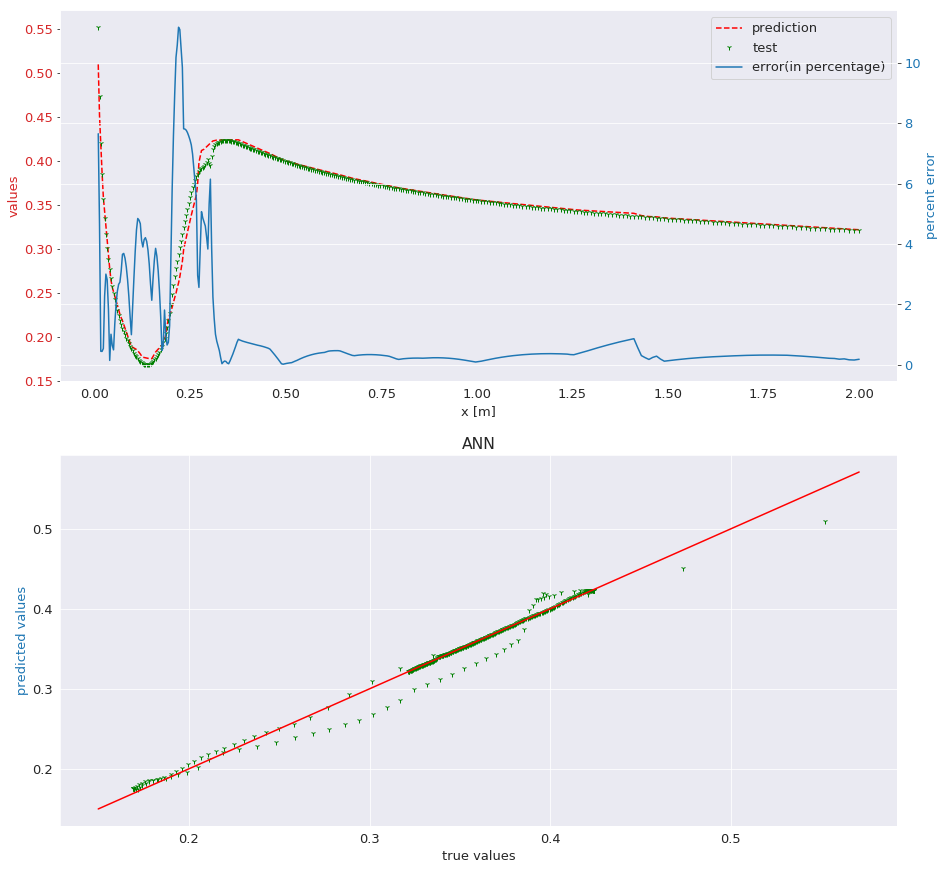

0.008285301186618995

In [102]:
# ANN prediction graph
prediction_graph(prediction,'ANN',(15,15))

In [105]:
score = rmsle_cv(lasso,type='lasso')
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.0948 (0.0176)



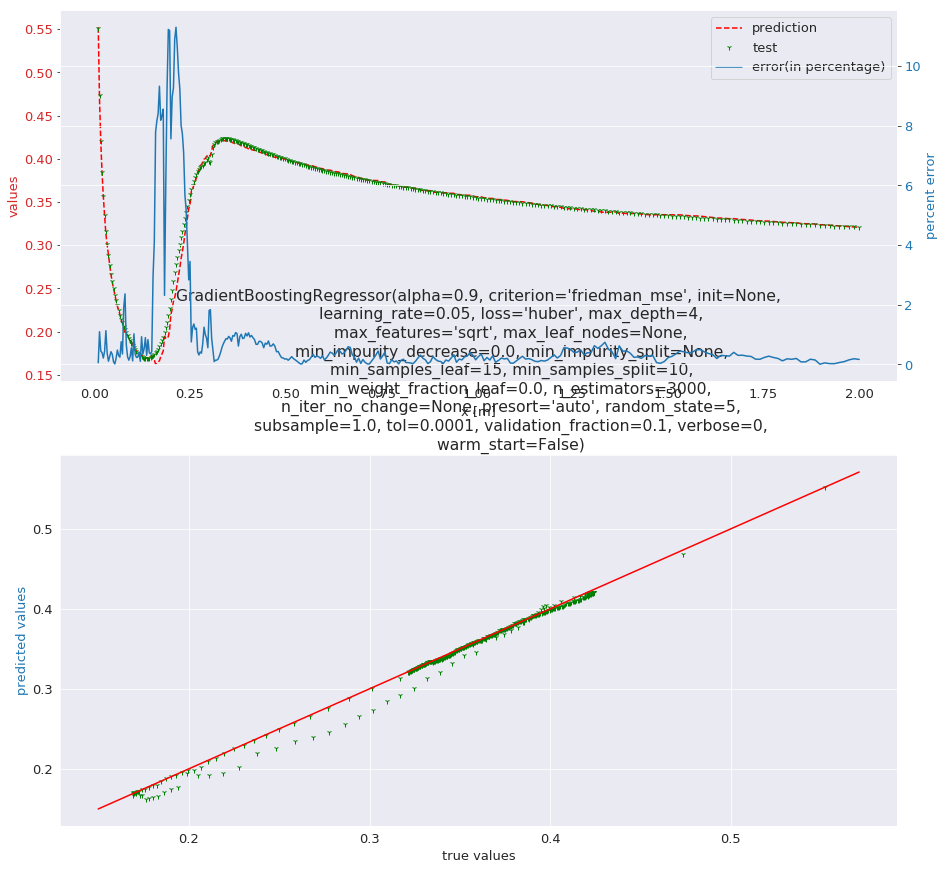

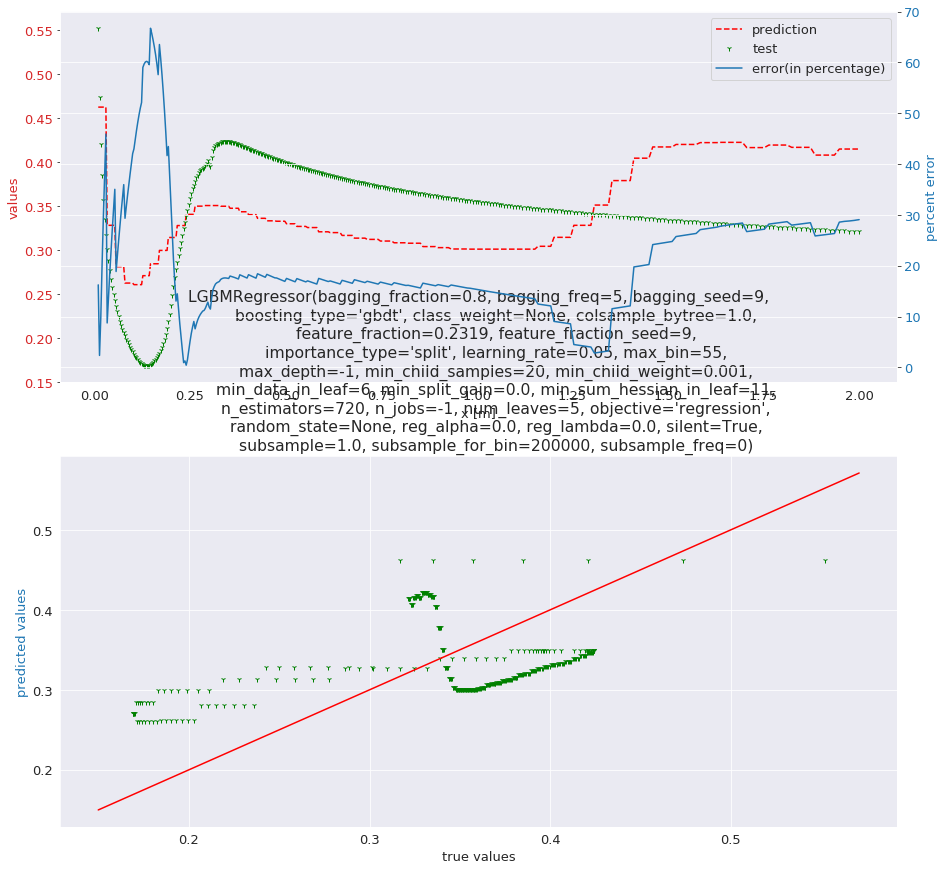

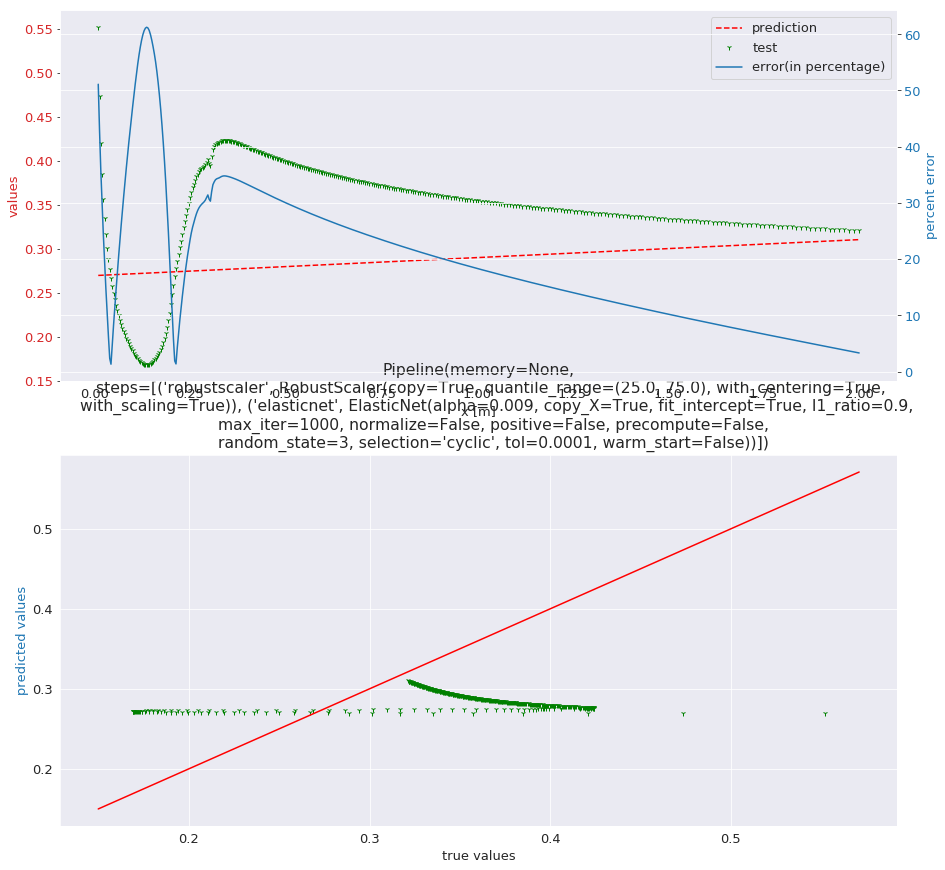

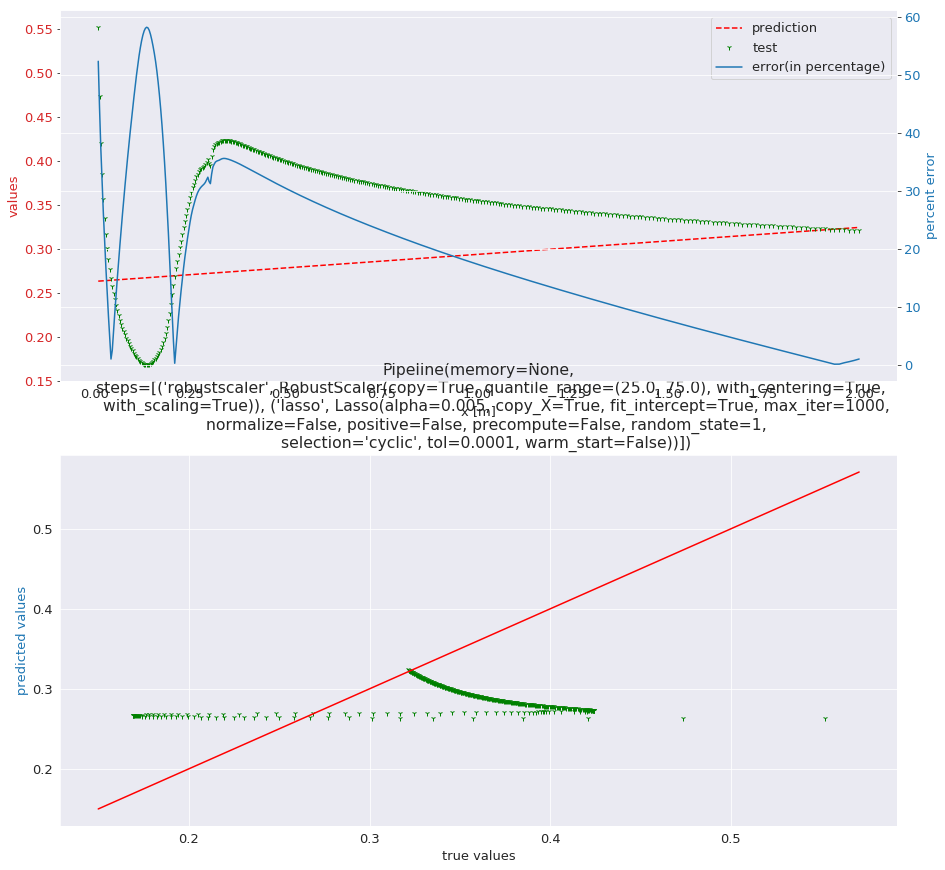

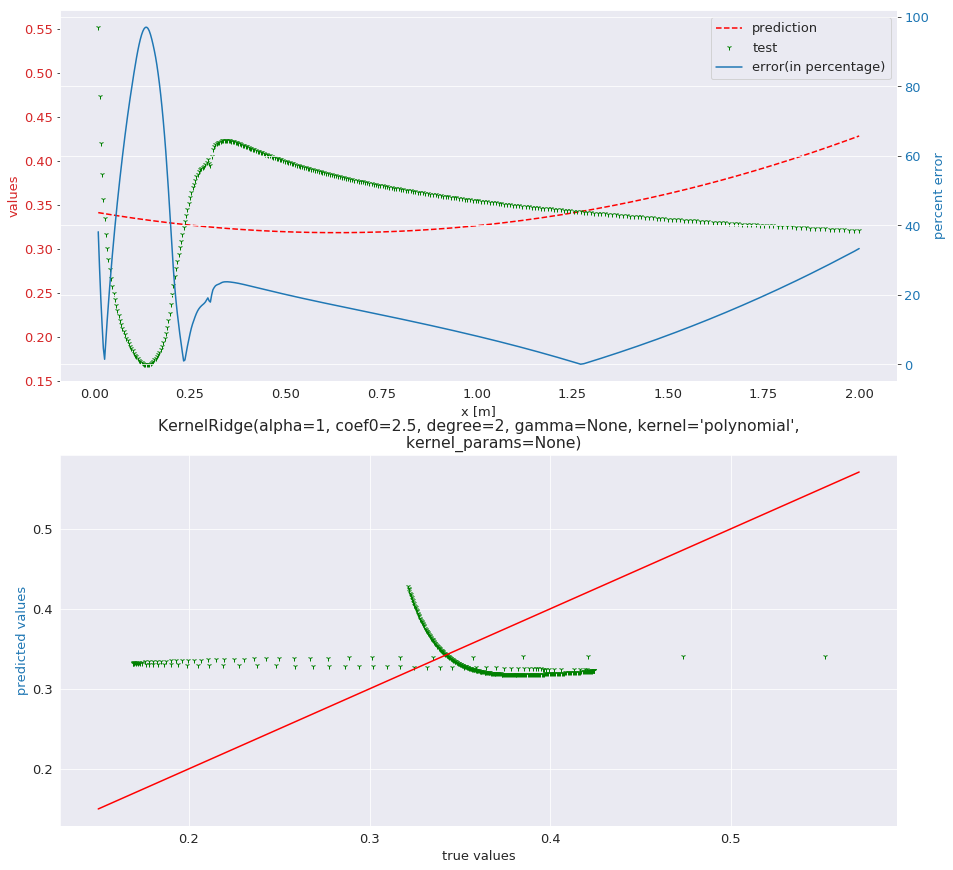

In [106]:
# prediction on test set without K-Fold
for model in models:
    model.fit(x_train,y_train)
    prediction = model.predict(x_test)
    prediction_graph(prediction,model,figsize=(15,15))

In [107]:
score = rmsle_cv(ENet,type='elasticnet')
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.0954 (0.0230)



In [108]:
score = rmsle_cv(KRR,type='kernelridge')
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.0822 (0.0113)



In [109]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.0240 (0.0057)



In [110]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.0863 (0.0092)



In [111]:
"""
depths=[5,6,7,8,9]
lr=[0.001,0.01,0.1,1]
nEst=[100,500,1000]
scores = []
fig,ax = plt.subplots(12,5,figsize=(3,3))
for lr in lr:
    for depth in depths:
        for n in nEst:
            model_xgb = xgb.XGBRegressor(max_depth=depth,learning_rate=lr,num_estimators=n,silent=True)
            model_xgb.fit(x_train.values,y_train)
            prediction = model_xgb.predict(x_test.values)
            score = prediction_graph(prediction,'depth:'+str(depth)+' lr:'+str(lr)+' nEstimators:'+str(n),figsize=(3,3))
            scores.append([score,depth,lr,n])
scores = np.asarray(scores)
minIndex = np.argmin(scores[:,0])
print(scores[minIndex,:])
# best was found at depth : 7 lr: 1 nEst : 100
"""

"\ndepths=[5,6,7,8,9]\nlr=[0.001,0.01,0.1,1]\nnEst=[100,500,1000]\nscores = []\nfig,ax = plt.subplots(12,5,figsize=(3,3))\nfor lr in lr:\n    for depth in depths:\n        for n in nEst:\n            model_xgb = xgb.XGBRegressor(max_depth=depth,learning_rate=lr,num_estimators=n,silent=True)\n            model_xgb.fit(x_train.values,y_train)\n            prediction = model_xgb.predict(x_test.values)\n            score = prediction_graph(prediction,'depth:'+str(depth)+' lr:'+str(lr)+' nEstimators:'+str(n),figsize=(3,3))\n            scores.append([score,depth,lr,n])\nscores = np.asarray(scores)\nminIndex = np.argmin(scores[:,0])\nprint(scores[minIndex,:])\n# best was found at depth : 7 lr: 1 nEst : 100\n"

In [ ]:
"""
gamma = [0.01,0.1,0,1,10]
min_child_weight = [0.01,0.1,1,10]
colsample_bytree = [0.01,0.1,1]
scores = []
for gm in gamma:
    for ch in min_child_weight:
        for cSample in colsample_bytree:
            model_xgb = xgb.XGBRegressor(max_depth=7,learning_rate=1,num_estimators=100,silent=True,gamma=gm,
                                        min_child_weight=ch,colsample_bytree=cSample)
            model_xgb.fit(x_train.values,y_train)
            prediction = model_xgb.predict(x_test.values)
            score = prediction_graph(prediction,'gamma:'+str(gm)+' child:'+str(ch)
                                     +' colsample:'+str(cSample),figsize=(10,5))
            scores.append([score,gm,ch,cSample])
scores = np.asarray(scores)
minIndex = np.argmin(scores[:,0])
print(scores[minIndex,:])
# best was found at gamma : 0 child: 0.01 colsample : 1
"""

In [112]:
model_xgb = xgb.XGBRegressor(max_depth=7,learning_rate=1,n_estimators=100,min_child_weight=0.01,
                            gamma=0,colsample_bytree=1)

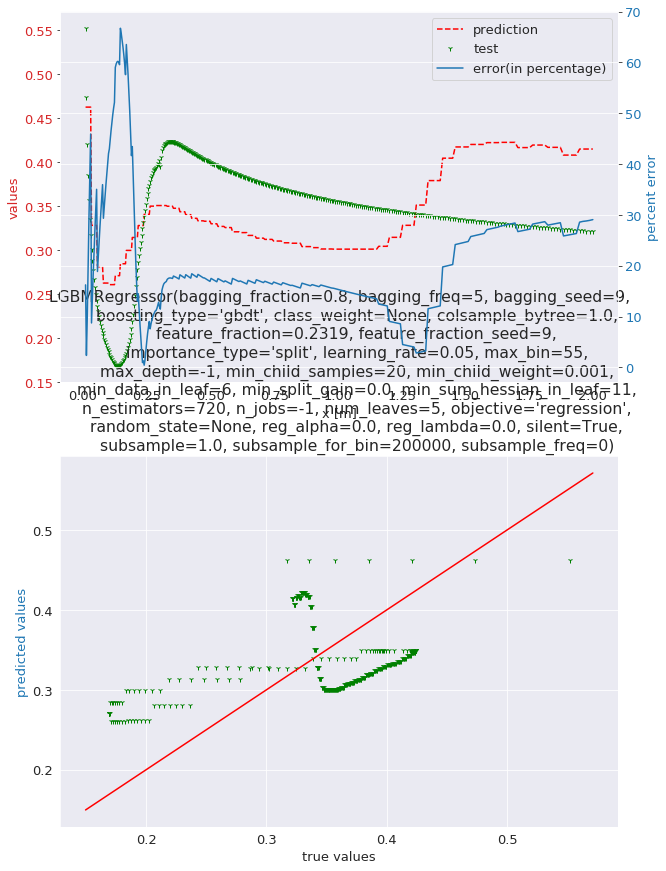

0.06931141659400061

In [113]:
model_lgb.fit(x_train,y_train)
prediction = model_lgb.predict(x_test)
prediction_graph(prediction,model_lgb,(10,15))

In [114]:
## Stacked Regression 

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)
        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

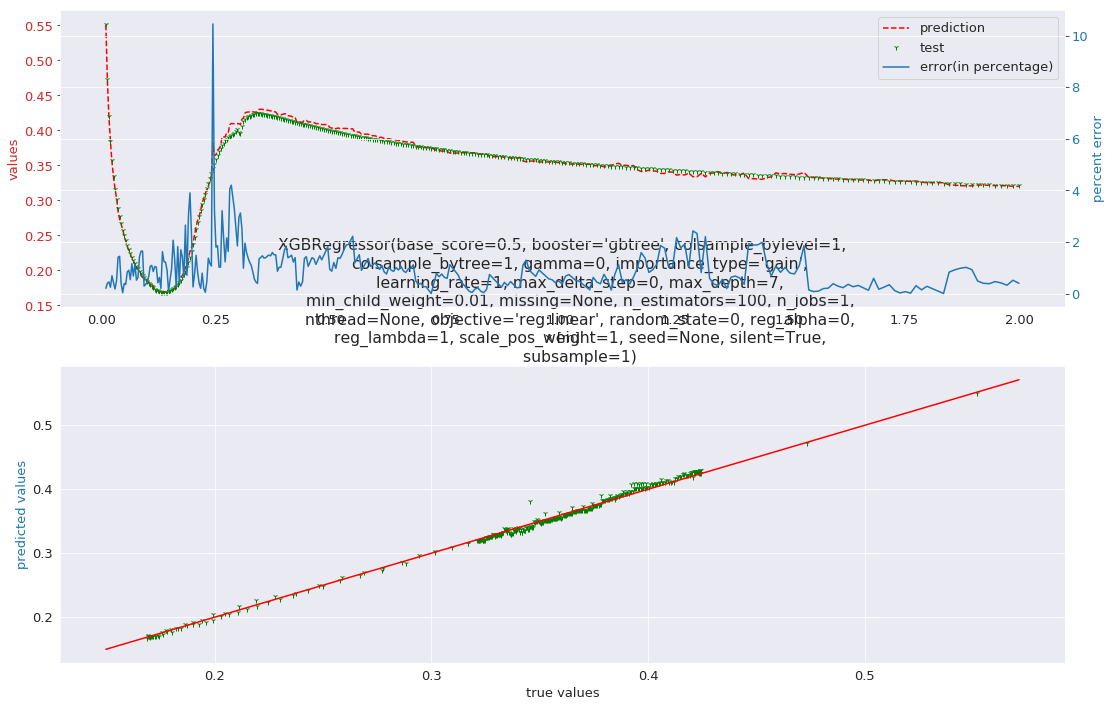

0.004743192537485135

In [115]:
model_xgb.fit(x_train.values,y_train)
prediction = model_xgb.predict(x_test.values)
prediction_graph(prediction,model_xgb,(18,12))

In [116]:
averaged_models = AveragingModels(models = (GBoost,ANNRegressor,model_xgb))

#score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.0863 (0.0092)



Train on 11534 samples, validate on 2884 samples
Epoch 1/100
11534/11534 [==============================] - 1s 56us/step - loss: 0.0957 - mean_absolute_error: 0.0957 - val_loss: 0.1361 - val_mean_absolute_error: 0.1361
Epoch 2/100
11534/11534 [==============================] - 0s 23us/step - loss: 0.0712 - mean_absolute_error: 0.0712 - val_loss: 0.1478 - val_mean_absolute_error: 0.1478
Epoch 3/100
11534/11534 [==============================] - 0s 23us/step - loss: 0.0620 - mean_absolute_error: 0.0620 - val_loss: 0.1171 - val_mean_absolute_error: 0.1171
Epoch 4/100
11534/11534 [==============================] - 0s 23us/step - loss: 0.0496 - mean_absolute_error: 0.0496 - val_loss: 0.0611 - val_mean_absolute_error: 0.0611
Epoch 5/100
11534/11534 [==============================] - 0s 25us/step - loss: 0.0390 - mean_absolute_error: 0.0390 - val_loss: 0.0355 - val_mean_absolute_error: 0.0355
Epoch 6/100
11534/11534 [==============================] - 0s 23us/step - loss: 0.0311 - mean_absolut

Epoch 49/100
11534/11534 [==============================] - 0s 22us/step - loss: 0.0103 - mean_absolute_error: 0.0103 - val_loss: 0.0270 - val_mean_absolute_error: 0.0270
Epoch 50/100
11534/11534 [==============================] - 0s 21us/step - loss: 0.0100 - mean_absolute_error: 0.0100 - val_loss: 0.0323 - val_mean_absolute_error: 0.0323
Epoch 51/100
11534/11534 [==============================] - 0s 22us/step - loss: 0.0113 - mean_absolute_error: 0.0113 - val_loss: 0.0309 - val_mean_absolute_error: 0.0309
Epoch 52/100
11534/11534 [==============================] - 0s 22us/step - loss: 0.0103 - mean_absolute_error: 0.0103 - val_loss: 0.0357 - val_mean_absolute_error: 0.0357
Epoch 53/100
11534/11534 [==============================] - 0s 22us/step - loss: 0.0093 - mean_absolute_error: 0.0093 - val_loss: 0.0341 - val_mean_absolute_error: 0.0341
Epoch 54/100
11534/11534 [==============================] - 0s 21us/step - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.0355 - val_me

11534/11534 [==============================] - 0s 22us/step - loss: 0.0061 - mean_absolute_error: 0.0061 - val_loss: 0.0232 - val_mean_absolute_error: 0.0232
Epoch 97/100
11534/11534 [==============================] - 0s 22us/step - loss: 0.0074 - mean_absolute_error: 0.0074 - val_loss: 0.0228 - val_mean_absolute_error: 0.0228
Epoch 98/100
11534/11534 [==============================] - 0s 22us/step - loss: 0.0079 - mean_absolute_error: 0.0079 - val_loss: 0.0223 - val_mean_absolute_error: 0.0223
Epoch 99/100
11534/11534 [==============================] - 0s 22us/step - loss: 0.0061 - mean_absolute_error: 0.0061 - val_loss: 0.0294 - val_mean_absolute_error: 0.0294
Epoch 100/100
11534/11534 [==============================] - 0s 23us/step - loss: 0.0067 - mean_absolute_error: 0.0067 - val_loss: 0.0248 - val_mean_absolute_error: 0.0248


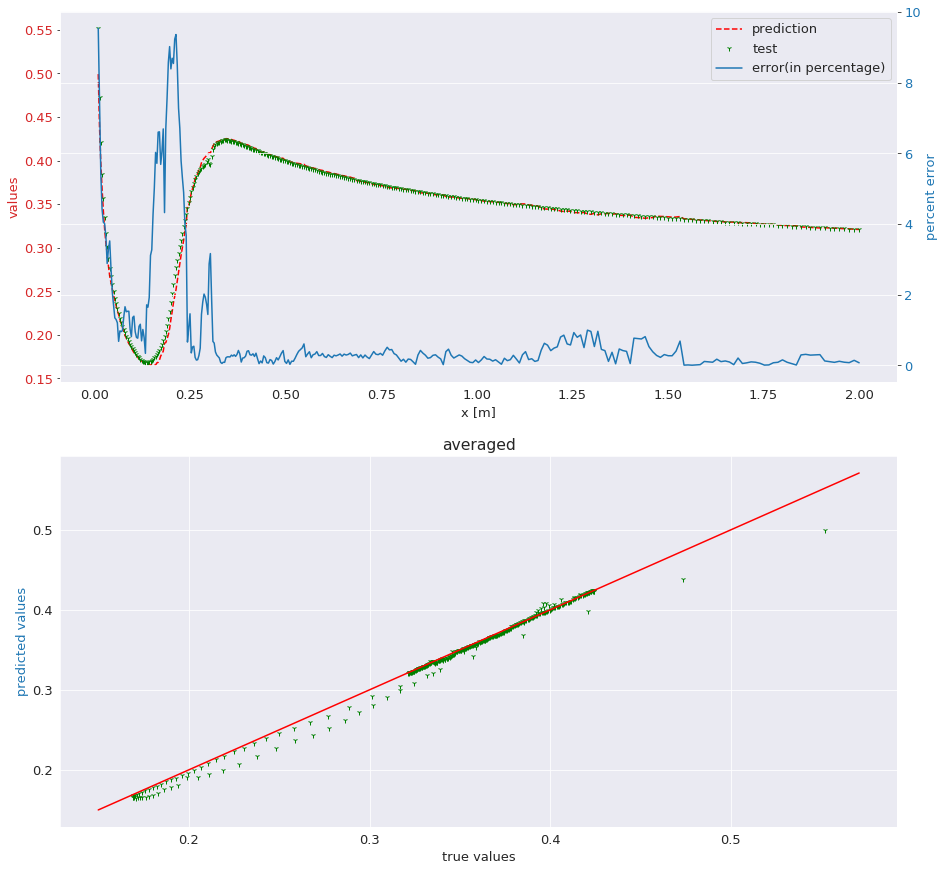

0.00666684569710817

In [117]:
averaged_models.fit(x_train.values,y_train)
prediction = averaged_models.predict(x_test.values)
prediction_graph(prediction,'averaged',figsize=(15,15))

In [118]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [119]:
#stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 #meta_model = lasso)

#score = rmsle_cv(stacked_averaged_models)
#print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

IndentationError: unexpected indent (<ipython-input-119-e40385a67836>, line 2)

In [120]:
stacked_averaged_models = StackingAveragedModels(base_models = (ANNRegressor, model_xgb),
                                                 meta_model = GBoost)


In [121]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [122]:
stacked_averaged_models.fit(x_train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(x_test.values)
print(rmsle(y_test, stacked_train_pred))

Train on 9227 samples, validate on 2307 samples
Epoch 1/100
9227/9227 [==============================] - 0s 54us/step - loss: 0.1063 - mean_absolute_error: 0.1063 - val_loss: 0.1095 - val_mean_absolute_error: 0.1095
Epoch 2/100
9227/9227 [==============================] - 0s 28us/step - loss: 0.0751 - mean_absolute_error: 0.0751 - val_loss: 0.0513 - val_mean_absolute_error: 0.0513
Epoch 3/100
9227/9227 [==============================] - 0s 31us/step - loss: 0.0688 - mean_absolute_error: 0.0688 - val_loss: 0.1028 - val_mean_absolute_error: 0.1028
Epoch 4/100
9227/9227 [==============================] - 0s 26us/step - loss: 0.0640 - mean_absolute_error: 0.0640 - val_loss: 0.1395 - val_mean_absolute_error: 0.1395
Epoch 5/100
9227/9227 [==============================] - 0s 34us/step - loss: 0.0555 - mean_absolute_error: 0.0555 - val_loss: 0.0723 - val_mean_absolute_error: 0.0723
Epoch 6/100
9227/9227 [==============================] - 0s 24us/step - loss: 0.0443 - mean_absolute_error: 0.04

9227/9227 [==============================] - 0s 25us/step - loss: 0.0145 - mean_absolute_error: 0.0145 - val_loss: 0.0268 - val_mean_absolute_error: 0.0268
Epoch 50/100
9227/9227 [==============================] - 0s 24us/step - loss: 0.0142 - mean_absolute_error: 0.0142 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 51/100
9227/9227 [==============================] - 0s 26us/step - loss: 0.0130 - mean_absolute_error: 0.0130 - val_loss: 0.0223 - val_mean_absolute_error: 0.0223
Epoch 52/100
9227/9227 [==============================] - 0s 26us/step - loss: 0.0133 - mean_absolute_error: 0.0133 - val_loss: 0.0216 - val_mean_absolute_error: 0.0216
Epoch 53/100
9227/9227 [==============================] - 0s 24us/step - loss: 0.0132 - mean_absolute_error: 0.0132 - val_loss: 0.0276 - val_mean_absolute_error: 0.0276
Epoch 54/100
9227/9227 [==============================] - 0s 27us/step - loss: 0.0126 - mean_absolute_error: 0.0126 - val_loss: 0.0189 - val_mean_absolute_error: 0.0189

9227/9227 [==============================] - 0s 24us/step - loss: 0.0078 - mean_absolute_error: 0.0078 - val_loss: 0.0117 - val_mean_absolute_error: 0.0117
Epoch 98/100
9227/9227 [==============================] - 0s 22us/step - loss: 0.0083 - mean_absolute_error: 0.0083 - val_loss: 0.0321 - val_mean_absolute_error: 0.0321
Epoch 99/100
9227/9227 [==============================] - 0s 23us/step - loss: 0.0087 - mean_absolute_error: 0.0087 - val_loss: 0.0165 - val_mean_absolute_error: 0.0165
Epoch 100/100
9227/9227 [==============================] - 0s 23us/step - loss: 0.0079 - mean_absolute_error: 0.0079 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Train on 9227 samples, validate on 2307 samples
Epoch 1/100
9227/9227 [==============================] - 1s 54us/step - loss: 0.1054 - mean_absolute_error: 0.1054 - val_loss: 0.0921 - val_mean_absolute_error: 0.0921
Epoch 2/100
9227/9227 [==============================] - 0s 25us/step - loss: 0.0734 - mean_absolute_error: 0.0734 - val

9227/9227 [==============================] - 0s 24us/step - loss: 0.0103 - mean_absolute_error: 0.0103 - val_loss: 0.0540 - val_mean_absolute_error: 0.0540
Epoch 46/100
9227/9227 [==============================] - 0s 26us/step - loss: 0.0109 - mean_absolute_error: 0.0109 - val_loss: 0.0373 - val_mean_absolute_error: 0.0373
Epoch 47/100
9227/9227 [==============================] - 0s 22us/step - loss: 0.0102 - mean_absolute_error: 0.0102 - val_loss: 0.0369 - val_mean_absolute_error: 0.0369
Epoch 48/100
9227/9227 [==============================] - 0s 23us/step - loss: 0.0093 - mean_absolute_error: 0.0093 - val_loss: 0.0345 - val_mean_absolute_error: 0.0345
Epoch 49/100
9227/9227 [==============================] - 0s 23us/step - loss: 0.0108 - mean_absolute_error: 0.0108 - val_loss: 0.0455 - val_mean_absolute_error: 0.0455
Epoch 50/100
9227/9227 [==============================] - 0s 25us/step - loss: 0.0097 - mean_absolute_error: 0.0097 - val_loss: 0.0327 - val_mean_absolute_error: 0.0327

9227/9227 [==============================] - 0s 26us/step - loss: 0.0082 - mean_absolute_error: 0.0082 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 94/100
9227/9227 [==============================] - 0s 23us/step - loss: 0.0077 - mean_absolute_error: 0.0077 - val_loss: 0.0393 - val_mean_absolute_error: 0.0393
Epoch 95/100
9227/9227 [==============================] - 0s 23us/step - loss: 0.0084 - mean_absolute_error: 0.0084 - val_loss: 0.0341 - val_mean_absolute_error: 0.0341
Epoch 96/100
9227/9227 [==============================] - 0s 23us/step - loss: 0.0081 - mean_absolute_error: 0.0081 - val_loss: 0.0347 - val_mean_absolute_error: 0.0347
Epoch 97/100
9227/9227 [==============================] - 0s 26us/step - loss: 0.0065 - mean_absolute_error: 0.0065 - val_loss: 0.0224 - val_mean_absolute_error: 0.0224
Epoch 98/100
9227/9227 [==============================] - 0s 24us/step - loss: 0.0084 - mean_absolute_error: 0.0084 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235

9227/9227 [==============================] - 0s 25us/step - loss: 0.0098 - mean_absolute_error: 0.0098 - val_loss: 0.0330 - val_mean_absolute_error: 0.0330
Epoch 42/100
9227/9227 [==============================] - 0s 23us/step - loss: 0.0099 - mean_absolute_error: 0.0099 - val_loss: 0.0455 - val_mean_absolute_error: 0.0455
Epoch 43/100
9227/9227 [==============================] - 0s 24us/step - loss: 0.0098 - mean_absolute_error: 0.0098 - val_loss: 0.0421 - val_mean_absolute_error: 0.0421
Epoch 44/100
9227/9227 [==============================] - 0s 24us/step - loss: 0.0098 - mean_absolute_error: 0.0098 - val_loss: 0.0287 - val_mean_absolute_error: 0.0287
Epoch 45/100
9227/9227 [==============================] - 0s 25us/step - loss: 0.0098 - mean_absolute_error: 0.0098 - val_loss: 0.0277 - val_mean_absolute_error: 0.0277
Epoch 46/100
9227/9227 [==============================] - 0s 24us/step - loss: 0.0096 - mean_absolute_error: 0.0096 - val_loss: 0.0378 - val_mean_absolute_error: 0.0378

9227/9227 [==============================] - 0s 25us/step - loss: 0.0077 - mean_absolute_error: 0.0077 - val_loss: 0.0272 - val_mean_absolute_error: 0.0272
Epoch 90/100
9227/9227 [==============================] - 0s 23us/step - loss: 0.0063 - mean_absolute_error: 0.0063 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 91/100
9227/9227 [==============================] - 0s 24us/step - loss: 0.0061 - mean_absolute_error: 0.0061 - val_loss: 0.0393 - val_mean_absolute_error: 0.0393
Epoch 92/100
9227/9227 [==============================] - 0s 24us/step - loss: 0.0077 - mean_absolute_error: 0.0077 - val_loss: 0.0403 - val_mean_absolute_error: 0.0403
Epoch 93/100
9227/9227 [==============================] - 0s 24us/step - loss: 0.0074 - mean_absolute_error: 0.0074 - val_loss: 0.0338 - val_mean_absolute_error: 0.0338
Epoch 94/100
9227/9227 [==============================] - 0s 24us/step - loss: 0.0074 - mean_absolute_error: 0.0074 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207

Epoch 37/100
9228/9228 [==============================] - 0s 24us/step - loss: 0.0109 - mean_absolute_error: 0.0109 - val_loss: 0.0202 - val_mean_absolute_error: 0.0202
Epoch 38/100
9228/9228 [==============================] - 0s 26us/step - loss: 0.0135 - mean_absolute_error: 0.0135 - val_loss: 0.0253 - val_mean_absolute_error: 0.0253
Epoch 39/100
9228/9228 [==============================] - 0s 23us/step - loss: 0.0115 - mean_absolute_error: 0.0115 - val_loss: 0.0278 - val_mean_absolute_error: 0.0278
Epoch 40/100
9228/9228 [==============================] - 0s 24us/step - loss: 0.0106 - mean_absolute_error: 0.0106 - val_loss: 0.0170 - val_mean_absolute_error: 0.0170
Epoch 41/100
9228/9228 [==============================] - 0s 25us/step - loss: 0.0102 - mean_absolute_error: 0.0102 - val_loss: 0.0202 - val_mean_absolute_error: 0.0202
Epoch 42/100
9228/9228 [==============================] - 0s 27us/step - loss: 0.0109 - mean_absolute_error: 0.0109 - val_loss: 0.0183 - val_mean_absolute_

9228/9228 [==============================] - 0s 25us/step - loss: 0.0079 - mean_absolute_error: 0.0079 - val_loss: 0.0194 - val_mean_absolute_error: 0.0194
Epoch 86/100
9228/9228 [==============================] - 0s 24us/step - loss: 0.0076 - mean_absolute_error: 0.0076 - val_loss: 0.0200 - val_mean_absolute_error: 0.0200
Epoch 87/100
9228/9228 [==============================] - 0s 25us/step - loss: 0.0070 - mean_absolute_error: 0.0070 - val_loss: 0.0202 - val_mean_absolute_error: 0.0202
Epoch 88/100
9228/9228 [==============================] - 0s 25us/step - loss: 0.0075 - mean_absolute_error: 0.0075 - val_loss: 0.0184 - val_mean_absolute_error: 0.0184
Epoch 89/100
9228/9228 [==============================] - 0s 26us/step - loss: 0.0073 - mean_absolute_error: 0.0073 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236
Epoch 90/100
9228/9228 [==============================] - 0s 25us/step - loss: 0.0071 - mean_absolute_error: 0.0071 - val_loss: 0.0246 - val_mean_absolute_error: 0.0246

9228/9228 [==============================] - 0s 27us/step - loss: 0.0106 - mean_absolute_error: 0.0106 - val_loss: 0.0222 - val_mean_absolute_error: 0.0222
Epoch 34/100
9228/9228 [==============================] - 0s 24us/step - loss: 0.0108 - mean_absolute_error: 0.0108 - val_loss: 0.0124 - val_mean_absolute_error: 0.0124
Epoch 35/100
9228/9228 [==============================] - 0s 24us/step - loss: 0.0085 - mean_absolute_error: 0.0085 - val_loss: 0.0117 - val_mean_absolute_error: 0.0117
Epoch 36/100
9228/9228 [==============================] - 0s 24us/step - loss: 0.0098 - mean_absolute_error: 0.0098 - val_loss: 0.0151 - val_mean_absolute_error: 0.0151
Epoch 37/100
9228/9228 [==============================] - 0s 26us/step - loss: 0.0094 - mean_absolute_error: 0.0094 - val_loss: 0.0195 - val_mean_absolute_error: 0.0195
Epoch 38/100
9228/9228 [==============================] - 0s 28us/step - loss: 0.0107 - mean_absolute_error: 0.0107 - val_loss: 0.0230 - val_mean_absolute_error: 0.0230

9228/9228 [==============================] - 0s 26us/step - loss: 0.0062 - mean_absolute_error: 0.0062 - val_loss: 0.0125 - val_mean_absolute_error: 0.0125
Epoch 82/100
9228/9228 [==============================] - 0s 28us/step - loss: 0.0072 - mean_absolute_error: 0.0072 - val_loss: 0.0154 - val_mean_absolute_error: 0.0154
Epoch 83/100
9228/9228 [==============================] - 0s 24us/step - loss: 0.0070 - mean_absolute_error: 0.0070 - val_loss: 0.0148 - val_mean_absolute_error: 0.0148
Epoch 84/100
9228/9228 [==============================] - 0s 26us/step - loss: 0.0067 - mean_absolute_error: 0.0067 - val_loss: 0.0097 - val_mean_absolute_error: 0.0097
Epoch 85/100
9228/9228 [==============================] - 0s 26us/step - loss: 0.0060 - mean_absolute_error: 0.0060 - val_loss: 0.0143 - val_mean_absolute_error: 0.0143
Epoch 86/100
9228/9228 [==============================] - 0s 26us/step - loss: 0.0075 - mean_absolute_error: 0.0075 - val_loss: 0.0174 - val_mean_absolute_error: 0.0174

In [123]:
overall_L1 = np.abs((np.subtract(y_test,stacked_train_pred))/y_test)*100
overall_L1 = np.sum(overall_L1)/overall_L1.shape[0]
overall_L1

0.7717762941423816

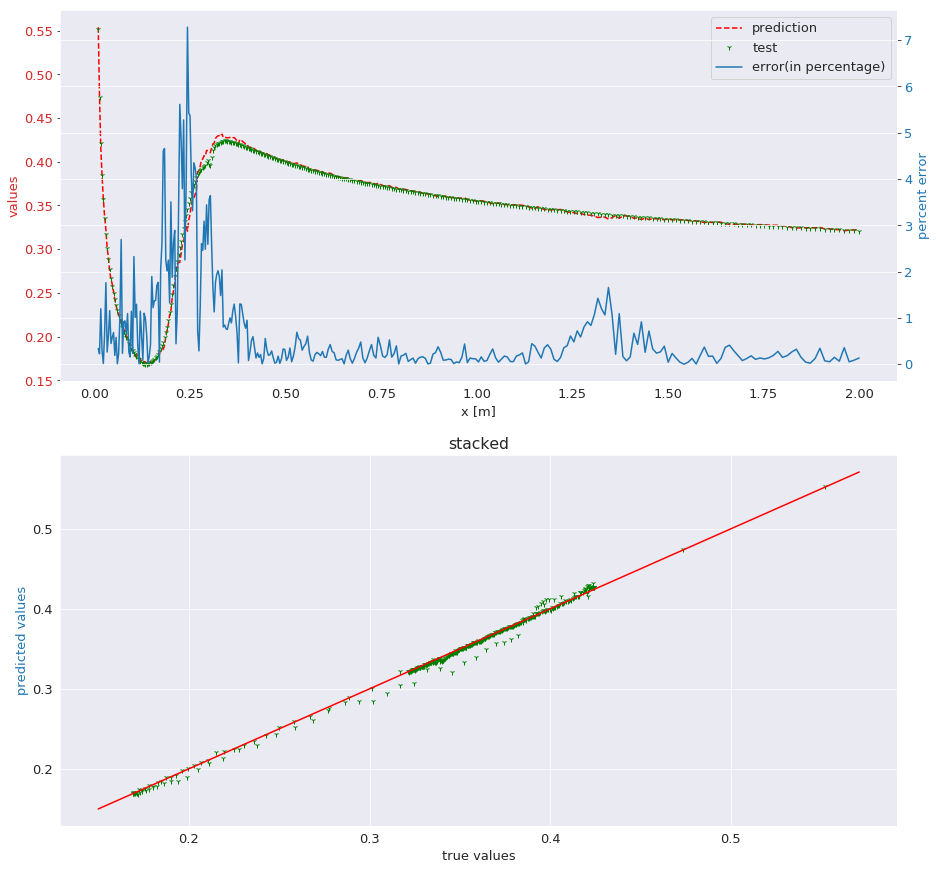

0.00457761983133317

In [124]:
prediction_graph(stacked_train_pred,'stacked',figsize=(15,15))

In [ ]:
x_test2 = x_test.values
x_test2[:,3] = np.add(x_test2[:,3],75)
x_test2[:,1] = np.add(x_test2[:,1],0.7)
stacked_train_pred = stacked_averaged_models.predict(x_test2)
print(rmsle(y_test, stacked_train_pred))
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(x_test2[:,0],stacked_train_pred,'g1')
plt.ylabel('x[m]', fontsize=13)
plt.xlabel('value', fontsize=13)
plt.show()